In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

In [2]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.
# 로그 변환
ts_log=np.log(ts)

In [3]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [4]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

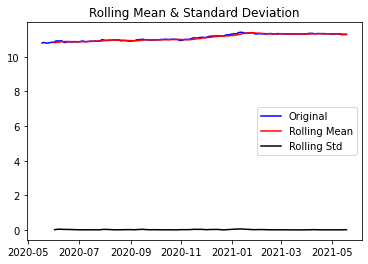

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


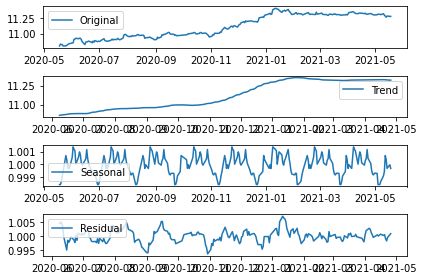

In [5]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.tight_layout()

In [6]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


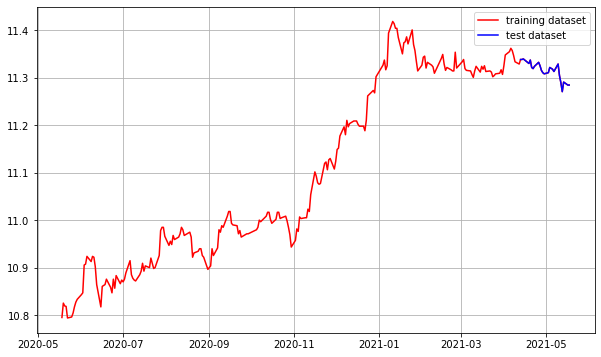

In [7]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

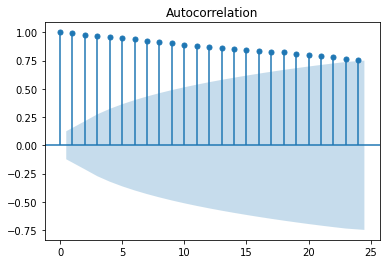

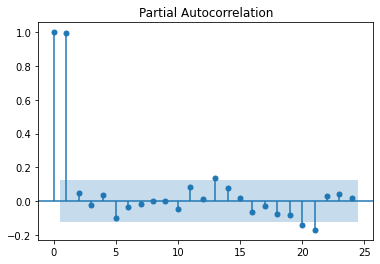

In [8]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


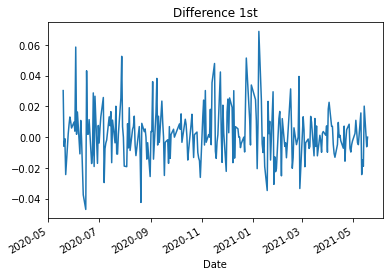

In [9]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [10]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 585.396
Method:                       css-mle   S.D. of innovations              0.018
Date:                Tue, 16 Nov 2021   AIC                          -1164.792
Time:                        06:03:25   BIC                          -1154.557
Sample:                             1   HQIC                         -1160.661
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      1.978      0.048    2.17e-05       0.005
ar.L1.D.Close     0.0168      0.067      0.250      0.803      -0.115       0.148
                                    Root

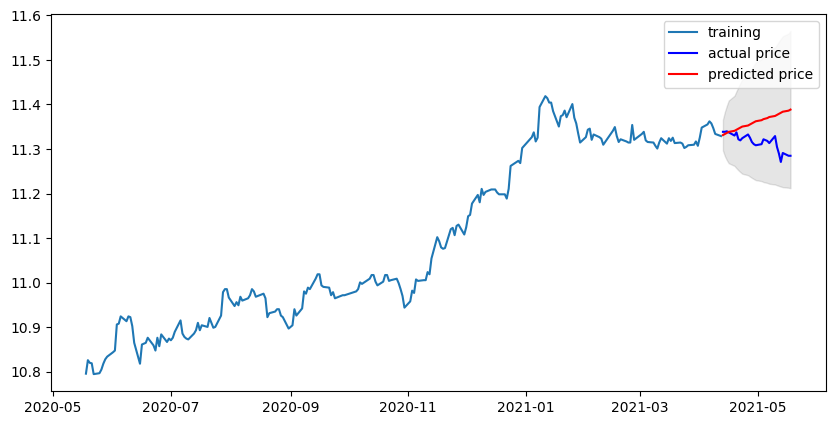

In [11]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:,0], index=test_data.index)
upper_series = pd.Series(conf[:,1], index=test_data.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  22087366.126154922
MAE:  3791.3511527213127
RMSE:  4699.719792301976
MAPE: 4.68%


In [13]:
def stock_set(dataset_filepath):
    df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
    ts = df['Close']
    ts.head()
    # 결측치 처리
    ts=ts.interpolate(method='time')
    ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.
    # 로그 변환
    ts_log=np.log(ts)
    
    return ts_log
    
    
def stock_decomposition(ts_log):
    # 정성적 그래프 분석
    plot_rolling_statistics(ts_log, window=12)

    #정량적 Augmented Dicky-Fuller Test
    print(augmented_dickey_fuller_test(ts_log))

    #시계열 분해 (Time Series Decomposition)
    from statsmodels.tsa.seasonal import seasonal_decompose
    decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.plot(ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonal')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residual')
    plt.legend(loc='best')
    plt.tight_layout()
    
    # Residual 안정성 확인
    residual.dropna(inplace=True)
    print(augmented_dickey_fuller_test(residual))
    
    
def stock_separation(ts_log):    
    train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.plot(ts_log, c='r', label='training dataset')
    plt.plot(test_data, c='b', label='test dataset')
    plt.legend()
    
    return train_data, test_data

def stock_show():
    # ACF, PACF 그려보기 -> p,q 구하기
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

    plot_acf(ts_log)
    plot_pacf(ts_log)
    plt.show()
    # 차분 안정성 확인 -> d 구하기
    diff_1 = ts_log.diff(periods=1).iloc[1:]
    diff_1.plot(title='Difference 1st')

    print(augmented_dickey_fuller_test(diff_1))
    
def stock_predict(train_data, test_data,p=1,d=1,q=0):
    import warnings
    warnings.filterwarnings('ignore') #경고 무시

    from statsmodels.tsa.arima_model import ARIMA

    model = ARIMA(train_data, order=(p, d, q))  
    fitted_m = model.fit() 

    print(fitted_m.summary())
    
    # Forecast : 결과가 fc에 담깁니다. 
    fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)
    lower_series = pd.Series(conf[:,0], index=test_data.index)
    upper_series = pd.Series(conf[:,1], index=test_data.index)

    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
    plt.legend()
    plt.show()
    
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    import math

    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))

    

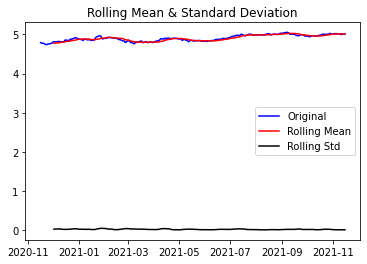

Results of Dickey-Fuller Test:
Test Statistic                  -1.613141
p-value                          0.476327
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64
None
Results of Dickey-Fuller Test:
Test Statistic                  -5.350964
p-value                          0.000004
#Lags Used                       0.000000
Number of Observations Used    221.000000
Critical Value (1%)             -3.460291
Critical Value (5%)             -2.874709
Critical Value (10%)            -2.573789
dtype: float64
None


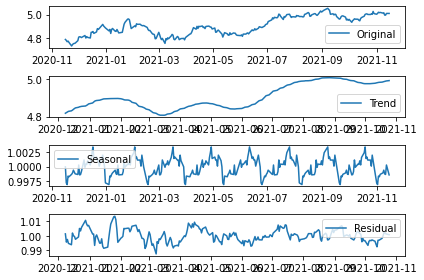

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/AAPL.csv'
ts_log = stock_set(dataset_filepath)
stock_decomposition(ts_log)

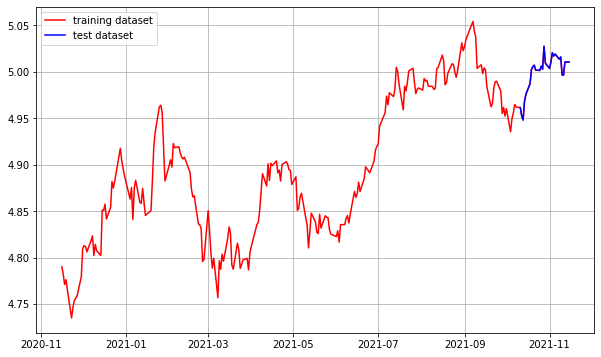

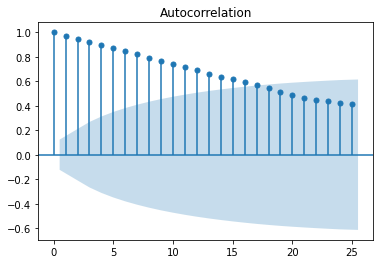

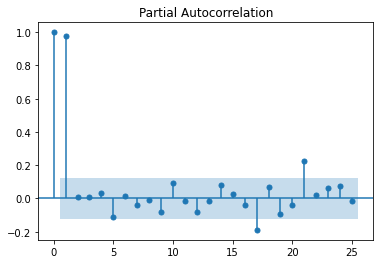

Results of Dickey-Fuller Test:
Test Statistic                -1.652795e+01
p-value                        2.035943e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64
None


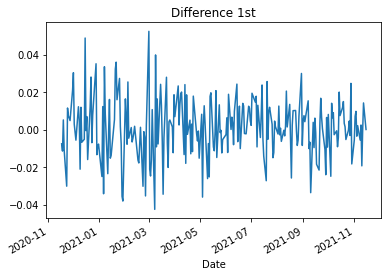

In [15]:
train_data, test_data = stock_separation(ts_log)
stock_show()

ACF의 경우 점차적으로 감소하고 있는 모델이므로 q를 0으로 놓고,  
PACF는 p가 2 이상인 구간에서 0에 가까워지는 모습을 보이므로 p=1로 설정한뒤 예측해보겠습니다.

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 610.733
Method:                       css-mle   S.D. of innovations              0.016
Date:                Tue, 16 Nov 2021   AIC                          -1215.465
Time:                        06:03:28   BIC                          -1205.217
Sample:                             1   HQIC                         -1211.329
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.001      0.752      0.452      -0.001       0.003
ar.L1.D.Close    -0.0470      0.066     -0.706      0.480      -0.177       0.083
                                    Root

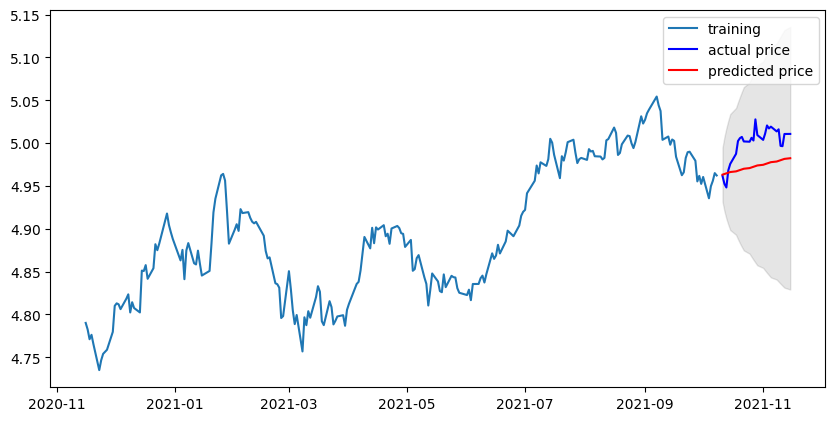

MSE:  21.246290531749672
MAE:  4.197549950744383
RMSE:  4.609369862763203
MAPE: 2.81%


In [16]:
stock_predict(train_data, test_data, p=1,d=1,q=0)

애플주식은 MAPE 2.81로 준수한 예측결과를 보입니다, 다른 종목도 예측해봅시다.  
제가 좋아하는 게임주로 해보겠습니다.

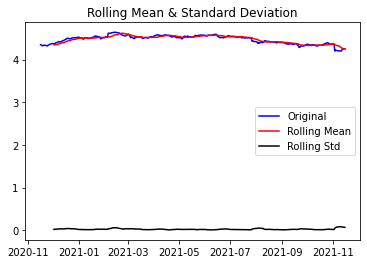

Results of Dickey-Fuller Test:
Test Statistic                  -1.053301
p-value                          0.733331
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64
None
Results of Dickey-Fuller Test:
Test Statistic                  -5.392000
p-value                          0.000004
#Lags Used                       5.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64
None


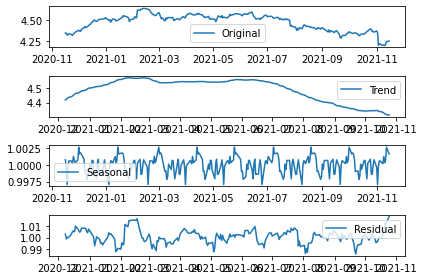

In [17]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/ATVI.csv'
ts_log = stock_set(dataset_filepath)
stock_decomposition(ts_log)

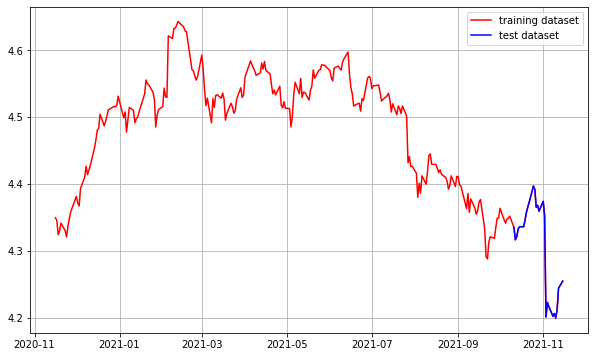

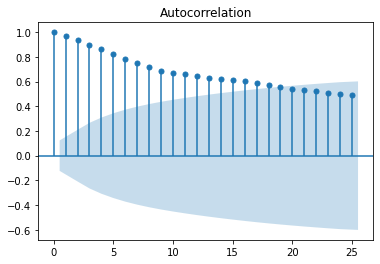

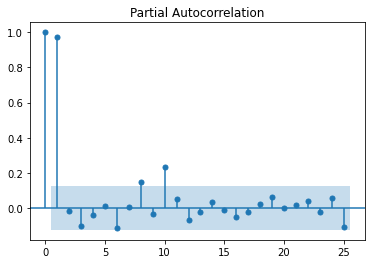

Results of Dickey-Fuller Test:
Test Statistic                -1.624307e+01
p-value                        3.710505e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64
None


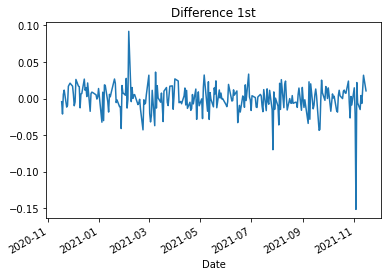

In [18]:
train_data, test_data = stock_separation(ts_log)
stock_show()

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 592.665
Method:                       css-mle   S.D. of innovations              0.017
Date:                Tue, 16 Nov 2021   AIC                          -1179.330
Time:                        06:08:38   BIC                          -1169.082
Sample:                             1   HQIC                         -1175.194
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          9.978e-06      0.001      0.009      0.993      -0.002       0.002
ar.L1.D.Close    -0.0528      0.066     -0.794      0.427      -0.183       0.077
                                    Root

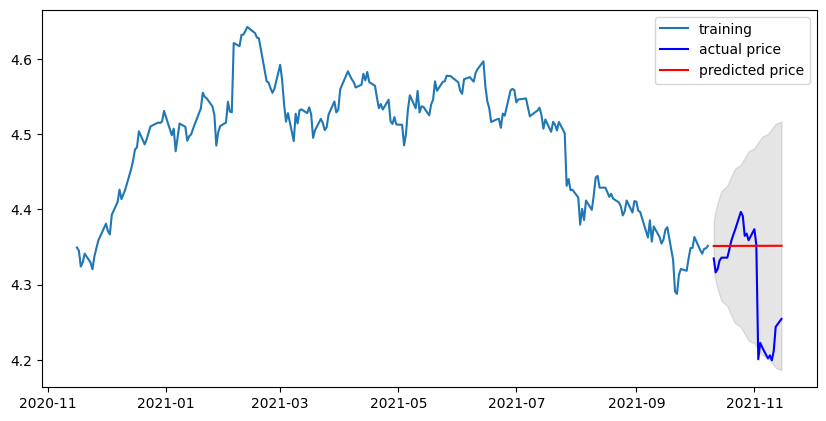

MSE:  35.318973078033544
MAE:  4.338942925885961
RMSE:  5.942976785924167
MAPE: 6.22%


In [22]:
stock_predict(train_data, test_data, p=1,d=1,q=0)

예측이 완전히 직선으로 나왔네요  
MAPE는 준수한데 뭔가 문제가 있는것인지?

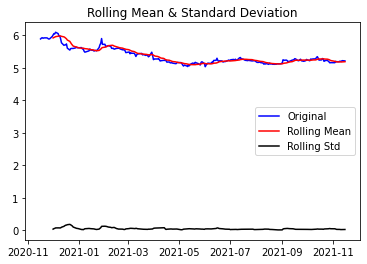

Results of Dickey-Fuller Test:
Test Statistic                  -2.111735
p-value                          0.239822
#Lags Used                       0.000000
Number of Observations Used    260.000000
Critical Value (1%)             -3.455754
Critical Value (5%)             -2.872721
Critical Value (10%)            -2.572728
dtype: float64
None
Results of Dickey-Fuller Test:
Test Statistic                -6.540474e+00
p-value                        9.374390e-09
#Lags Used                     1.000000e+00
Number of Observations Used    2.290000e+02
Critical Value (1%)           -3.459233e+00
Critical Value (5%)           -2.874245e+00
Critical Value (10%)          -2.573541e+00
dtype: float64
None


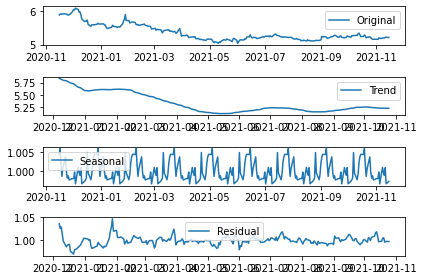

In [24]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/CDR.WA.csv'
ts_log = stock_set(dataset_filepath)
stock_decomposition(ts_log)

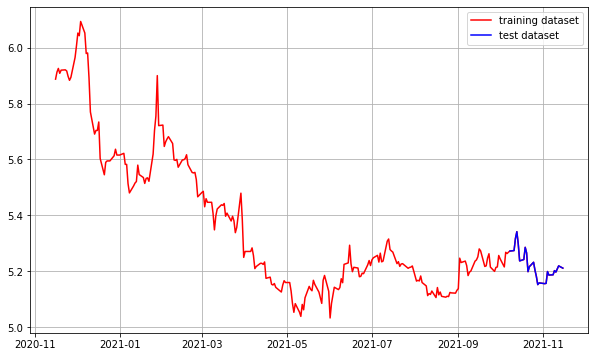

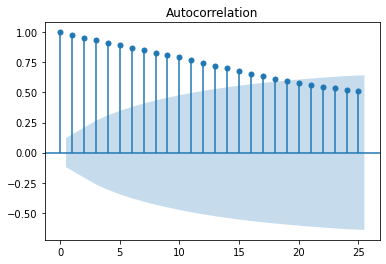

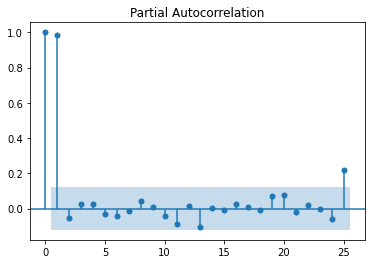

Results of Dickey-Fuller Test:
Test Statistic                -1.215482e+01
p-value                        1.540681e-22
#Lags Used                     1.000000e+00
Number of Observations Used    2.580000e+02
Critical Value (1%)           -3.455953e+00
Critical Value (5%)           -2.872809e+00
Critical Value (10%)          -2.572775e+00
dtype: float64
None


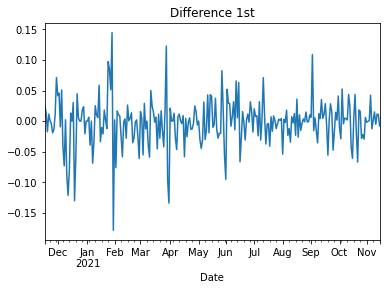

In [25]:
train_data, test_data = stock_separation(ts_log)
stock_show()

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  233
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 425.757
Method:                       css-mle   S.D. of innovations              0.039
Date:                Tue, 16 Nov 2021   AIC                           -845.514
Time:                        06:09:55   BIC                           -835.161
Sample:                    11-17-2020   HQIC                          -841.339
                         - 10-07-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0027      0.003     -1.018      0.309      -0.008       0.002
ar.L1.D.Close     0.0217      0.065      0.331      0.740      -0.107       0.150
                                    Root

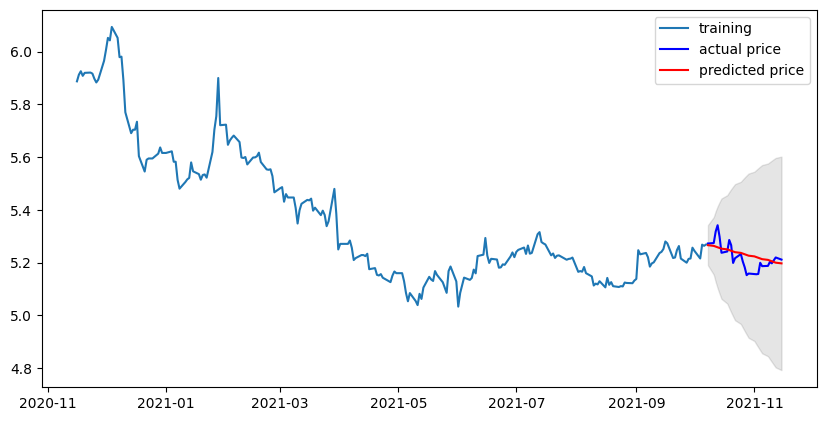

MSE:  58.38566779884918
MAE:  6.137707756162577
RMSE:  7.6410514851589095
MAPE: 3.33%


In [26]:
stock_predict(train_data, test_data, p=1,d=1,q=0)

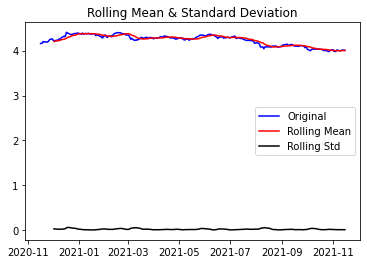

Results of Dickey-Fuller Test:
Test Statistic                  -0.615757
p-value                          0.867382
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64
None
Results of Dickey-Fuller Test:
Test Statistic                -5.743599e+00
p-value                        6.194222e-07
#Lags Used                     7.000000e+00
Number of Observations Used    2.140000e+02
Critical Value (1%)           -3.461282e+00
Critical Value (5%)           -2.875143e+00
Critical Value (10%)          -2.574020e+00
dtype: float64
None


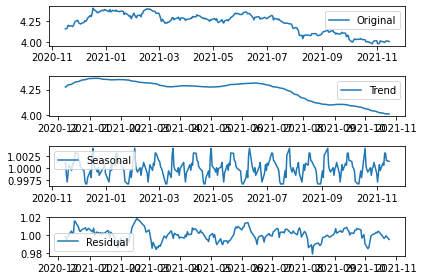

In [27]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/NTDOY.csv'
ts_log = stock_set(dataset_filepath)
stock_decomposition(ts_log)

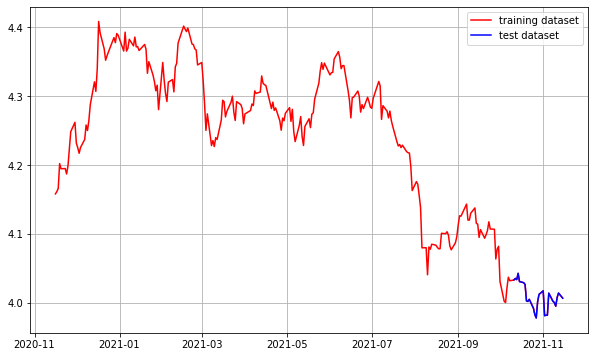

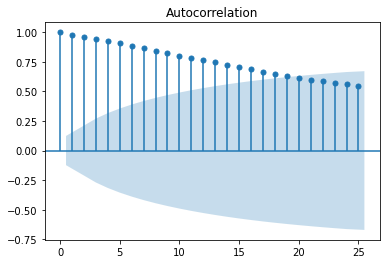

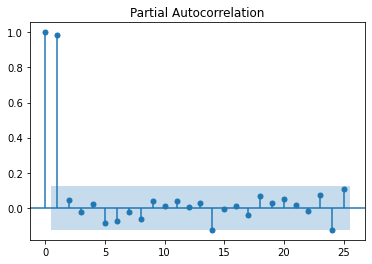

Results of Dickey-Fuller Test:
Test Statistic                -1.661584e+01
p-value                        1.714934e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64
None


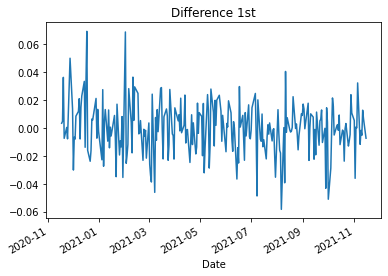

In [28]:
train_data, test_data = stock_separation(ts_log)
stock_show()

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 569.999
Method:                       css-mle   S.D. of innovations              0.019
Date:                Tue, 16 Nov 2021   AIC                          -1133.998
Time:                        06:10:35   BIC                          -1123.749
Sample:                             1   HQIC                         -1129.861
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0006      0.001     -0.461      0.645      -0.003       0.002
ar.L1.D.Close    -0.0526      0.066     -0.791      0.429      -0.183       0.078
                                    Root

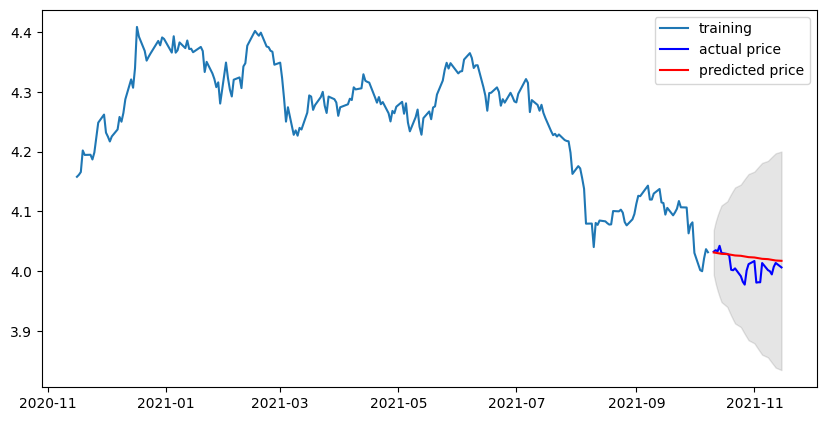

MSE:  1.6702312674408242
MAE:  1.014087639646494
RMSE:  1.2923742752936644
MAPE: 1.87%


In [29]:
stock_predict(train_data, test_data, p=1,d=1,q=0)